# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [3]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [4]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [5]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [6]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [7]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [8]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [9]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [10]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [11]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [12]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [13]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [14]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [15]:
# https://stackoverflow.com/a/47091490/4084039
import re
from bs4 import BeautifulSoup
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [16]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [17]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 87773/87773 [01:22<00:00, 1064.34it/s]


In [23]:
preprocessed_reviews[1500]

'wow far two two star reviews one obviously no idea ordering wants crispy cookies hey sorry reviews nobody good beyond reminding us look ordering chocolate oatmeal cookies not like combination not order type cookie find combo quite nice really oatmeal sort calms rich chocolate flavor gives cookie sort coconut type consistency let also remember tastes differ given opinion soft chewy cookies advertised not crispy cookies blurb would say crispy rather chewy happen like raw cookie dough however not see taste like raw cookie dough soft however confusion yes stick together soft cookies tend not individually wrapped would add cost oh yeah chocolate chip cookies tend somewhat sweet want something hard crisp suggest nabiso ginger snaps want cookie soft chewy tastes like combination chocolate oatmeal give try place second order'

# [4] Featurization

## [4.1] BAG OF WORDS

In [25]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aahhhs', 'aback', 'abandon', 'abates', 'abbott', 'abby', 'abdominal', 'abiding', 'ability']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 12997)
the number of unique words  12997


## [4.2] Bi-Grams and n-Grams.

In [26]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.3] TF-IDF

In [27]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able find', 'able get', 'absolute', 'absolutely', 'absolutely delicious', 'absolutely love', 'absolutely no', 'according']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.4] Word2Vec

In [28]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [29]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('tasty', 0.9968437552452087), ('flavorful', 0.9963862895965576), ('aftertaste', 0.9960881471633911), ('enjoy', 0.9958664178848267), ('describe', 0.9957375526428223), ('salty', 0.9957354664802551), ('bitterness', 0.9956967234611511), ('crunch', 0.9956904649734497), ('greasy', 0.9955406188964844), ('light', 0.9955061674118042)]
[('provides', 0.9994629621505737), ('perhaps', 0.9994308948516846), ('popcorn', 0.9994221925735474), ('stand', 0.9994176626205444), ('lover', 0.9993991255760193), ('must', 0.9993771910667419), ('become', 0.999374508857727), ('oils', 0.9993670582771301), ('audio', 0.999359130859375), ('cherry', 0.9993506669998169)]


In [30]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  3817
sample words  ['product', 'available', 'course', 'total', 'pretty', 'stinky', 'right', 'nearby', 'used', 'ca', 'not', 'beat', 'great', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'removed', 'easily', 'daughter', 'designed', 'printed', 'use', 'car', 'windows', 'beautifully', 'shop', 'program', 'going', 'lot', 'fun', 'everywhere', 'like', 'tv', 'computer', 'really', 'good', 'idea', 'final', 'outstanding', 'window', 'everybody', 'asks', 'bought', 'made']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [31]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|█████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:09<00:00, 512.67it/s]


4986
50


#### [4.4.1.2] TFIDF weighted W2v

In [32]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [33]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:53<00:00, 93.11it/s]


# Applying Logistic Regression

## [5.1] Logistic Regression on BOW,<font color='red'> SET 1</font>

### [5.1.1] Applying Logistic Regression with L1 regularization on BOW,<font color='red'> SET 1</font>

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from scipy.sparse import csr_matrix

In [20]:
#splitting the data into train and test
score = final['Score']
x_train, x_test, y_train, y_test = train_test_split(preprocessed_reviews, score, test_size = 0.2 )

count_vect = CountVectorizer(ngram_range = (1,2),min_df = 10)
#bow vectorization
train_bow = count_vect.fit_transform(x_train)
test_bow = count_vect.transform(x_test)

In [22]:
#using GridSearchCV
tuned_parameters = {'C':[10**-4, 10**-3, 10**-2, 10**-1, 1, 10, 10**2,10**3, 10**4]}
model = GridSearchCV(LogisticRegression(penalty = 'l1',solver='liblinear'), tuned_parameters, n_jobs=-1, scoring = 'roc_auc', cv = 5 )
model.fit(train_bow, y_train)

GridSearchCV(cv=5,
             estimator=LogisticRegression(penalty='l1', solver='liblinear'),
             n_jobs=-1,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000,
                               10000]},
             scoring='roc_auc')

In [23]:
result = model.cv_results_
result = pd.DataFrame(result)
result

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,2.385308,0.313299,0.053604,0.021663,0.0001,{'C': 0.0001},0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000,9
1,4.260032,1.002893,0.055408,0.010709,0.001,{'C': 0.001},0.719007,0.724967,0.720510,0.726399,0.714909,0.721158,0.004149,8
2,4.518776,0.530972,0.056117,0.007203,0.01,{'C': 0.01},0.880417,0.884377,0.881894,0.889094,0.881330,0.883423,0.003125,7
3,5.991573,0.634431,0.038805,0.019916,0.1,{'C': 0.1},0.940827,0.942521,0.943856,0.944305,0.944512,0.943204,0.001376,2
4,10.991323,1.561975,0.046003,0.018903,1,{'C': 1},0.945701,0.948356,0.946318,0.949059,0.950110,0.947909,0.001660,1
5,17.721762,0.916479,0.034409,0.004500,10,{'C': 10},0.936135,0.938069,0.938286,0.937895,0.941130,0.938303,0.001607,3
6,15.254734,2.249193,0.041803,0.003190,100,{'C': 100},0.933310,0.935540,0.932707,0.936175,0.937546,0.935056,0.001803,4
7,12.222658,2.059273,0.037202,0.005034,1000,{'C': 1000},0.930666,0.934017,0.930970,0.934084,0.934856,0.932919,0.001743,5
8,5.134805,1.561152,0.017406,0.006284,10000,{'C': 10000},0.919110,0.915573,0.915299,0.918759,0.915933,0.916935,0.001649,6


[-4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0]


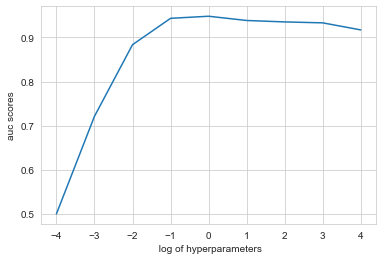

In [25]:
x = result['param_C'].values
y = result['mean_test_score'].values
from math import log10
x = [log10(i) for i in x]
print(x)
sns.set_style("whitegrid")
plt.plot(x,y)
plt.xlabel(' log of hyperparameters')
plt.ylabel('auc scores')
plt.show()

In [27]:
print(model.best_estimator_)


LogisticRegression(C=1, penalty='l1', solver='liblinear')


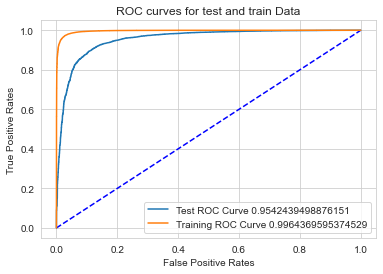

In [30]:
#plotting ROC Curves
from sklearn.metrics import roc_curve,roc_auc_score
pred_prob = model.predict_proba(test_bow)
pred_train_prob = model.predict_proba(train_bow)
train_roc = roc_auc_score(y_train, pred_train_prob[:,1])
test_roc = roc_auc_score(y_test,pred_prob[:,1])
fpr, tpr, thresholds = roc_curve(y_test,pred_prob[:,1])
fpr1 ,tpr1, thresholds = roc_curve(y_train, pred_train_prob[:,1])

plt.plot([0,1],[0,1],'b--')
plt.plot(fpr,tpr, label = "Test ROC Curve "+ str(test_roc))
plt.plot(fpr1,tpr1,label = "Training ROC Curve " + str(train_roc))
plt.legend()
plt.xlabel("False Positive Rates")
plt.ylabel("True Positive Rates")
plt.title("ROC curves for test and train Data")
plt.show()


<Figure size 360x360 with 0 Axes>

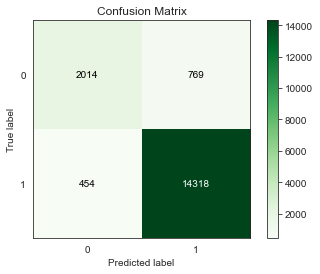

In [34]:
import scikitplot as skplt
sns.set_style("white")
plt.figure(figsize = (5,5))
predicted = model.predict(test_bow)
skplt.metrics.plot_confusion_matrix(y_test, predicted, cmap = 'Greens')
plt.show()

#### [5.1.1.1] Calculating sparsity on weight vector obtained using L1 regularization on BOW,<font color='red'> SET 1</font>

In [36]:
#storing value of w
clf = LogisticRegression(C = 1 , penalty = 'l1', n_jobs = -1, solver = "liblinear")
clf.fit(train_bow, y_train)
w = clf.coef_
print(w)

[[0. 0. 0. ... 0. 0. 0.]]


In [37]:
print(w.shape)
print(np.count_nonzero(w))

(1, 41561)
6872


### [5.1.2] Applying Logistic Regression with L2 regularization on BOW,<font color='red'> SET 1</font>

In [38]:
model = GridSearchCV(LogisticRegression(penalty = 'l2', n_jobs = -1), tuned_parameters, cv = 10, scoring = 'roc_auc', n_jobs = -1 )
model.fit(train_bow, y_train)
print(model.best_estimator_)
print(model.score(test_bow, y_test))

LogisticRegression(C=0.1, n_jobs=-1)
0.959230428273319


[-4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0]


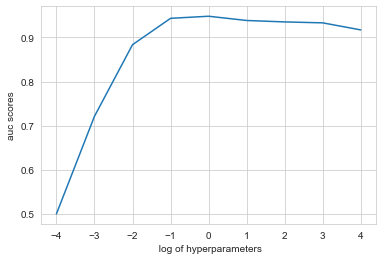

In [39]:
x = result['param_C'].values
y = result['mean_test_score'].values
from math import log10
x = [log10(i) for i in x]
print(x)
sns.set_style("whitegrid")
plt.plot(x,y)
plt.xlabel(' log of hyperparameters')
plt.ylabel('auc scores')
plt.show()

In [40]:
from sklearn.metrics import roc_auc_score
pred_bow = model.predict_proba(test_bow)
print('AUC is: ', roc_auc_score(y_test, (pred_bow[:, 1])))


AUC is:  0.959230428273319


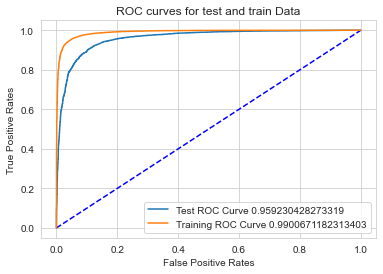

In [41]:
#plotting ROC Curves
from sklearn.metrics import roc_curve,roc_auc_score
pred_prob = model.predict_proba(test_bow)
pred_train_prob = model.predict_proba(train_bow)
train_roc = roc_auc_score(y_train, pred_train_prob[:,1])
test_roc = roc_auc_score(y_test,pred_prob[:,1])
fpr, tpr, thresholds = roc_curve(y_test,pred_prob[:,1])
fpr1 ,tpr1, thresholds = roc_curve(y_train, pred_train_prob[:,1])

plt.plot([0,1],[0,1],'b--')
plt.plot(fpr,tpr, label = "Test ROC Curve "+ str(test_roc))
plt.plot(fpr1,tpr1,label = "Training ROC Curve " + str(train_roc))
plt.legend()
plt.xlabel("False Positive Rates")
plt.ylabel("True Positive Rates")
plt.title("ROC curves for test and train Data")
plt.show()


<Figure size 360x360 with 0 Axes>

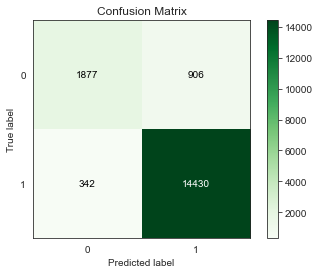

In [42]:
import scikitplot as skplt
sns.set_style("white")
plt.figure(figsize = (5,5))
predicted = model.predict(test_bow)
skplt.metrics.plot_confusion_matrix(y_test, predicted, cmap = 'Greens')
plt.show()

#### [5.1.2.1] Performing pertubation test (multicollinearity check) on BOW,<font color='red'> SET 1</font>

In [43]:
#pertubation test on l1 penalised bow linear regression model
import copy
Noise_data = copy.deepcopy(train_bow)
e = np.random.normal(0, 0.001)
Noise_data.data= Noise_data.data + e
print(Noise_data.shape)
print(train_bow.shape)

(70218, 41561)
(70218, 41561)


In [48]:
model =LogisticRegression(C=0.1, n_jobs=-1)
model.fit(train_bow, y_train)
w = model.coef_
#fitting noise data on the model
model.fit(Noise_data, y_train)
w1 = model.coef_
print(w1.shape)
print(w1)

(1, 41561)
[[0.03204379 0.06118994 0.01819154 ... 0.00887589 0.04748935 0.00640349]]


In [57]:
print(w)
print(w1)
perc_change = (abs(w-w1)/w)*100
print(perc_change)
print(len(w[0]))

[[0.03203574 0.06117278 0.01820396 ... 0.00884571 0.04747687 0.0063443 ]]
[[0.03204479 0.06119094 0.01819254 ... 0.00887689 0.04749035 0.00640449]]
[[0.02824985 0.02969592 0.06273865 ... 0.35251781 0.02839081 0.94877772]]
41561


In [58]:
feature_names = count_vect.get_feature_names()
#creating a dictionary having perc_change as key and feature_name as value
perc_change_feat = dict(zip(perc_change[0], feature_names))
print('multi collinear features are :')
c =0 
#printing those features which have a perc_change of more than 2.5
for i in perc_change[0] :
    if i > 2.5:
        print(perc_change_feat[i])
        c+=1
print(c)     

multi collinear features are :
accounts
adding extra
ads
adulterated
affordable price
aggressive
alleged
almond bars
alpha
amazon highly
amazon make
amazon save
amazon yet
anchovies
another cup
appear
aroma coffee
association
auto order
bad think
beans purchased
beneful
best food
best make
best market
beta
better would
bile
binge
black bean
black cherry
bought love
box chocolate
box try
brand dog
bubbles
buy
buy try
calculated
candy bars
cane syrup
cast iron
catch
cause diarrhea
cayenne
cell
center
chinatown
chopped
coffee beans
complementary
constipation
costco stopped
crates
creature
cup brew
daily use
day could
days not
days row
delicious bread
desperation
different food
dog biscuit
dog treats
dollars per
dried liver
dropped
easy mix
easy way
eat large
effectiveness
enjoy without
enough know
enticing
entire pack
equal parts
evening snack
event
ever bought
expectations
fact
fact not
farm
feed dry
find product
first like
flavor goes
flavors added
floral
food industry
food know
food qu

### [5.1.3] Feature Importance on BOW,<font color='red'> SET 1</font>

#### [5.1.3.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [70]:
#creating a weight vector dict
weight_vect = dict(zip(w[0], feature_names))
print('most important features of positive class are :')
w0 = sorted(w[0].data, reverse = True)
for i in range(0,10):
    print('%20s\t\t\t%f\t'%(weight_vect[w0[i]],w0[i]))
    
    


most important features of positive class are :
    not disappointed			1.714847	
           delicious			1.539178	
           excellent			1.331547	
             perfect			1.295785	
             amazing			1.228939	
               loves			1.174836	
               yummy			1.144226	
           wonderful			1.135372	
          not bitter			1.134895	
               great			1.119295	


#### [5.1.3.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [71]:

print('most important features of negative class are :')
for i in range (-1, -11, -1):
    print('%20s\t\t\t%f\t'%(weight_vect[w0[i]],w0[i]))

most important features of negative class are :
           not worth			-1.784492	
               worst			-1.760650	
       not recommend			-1.589363	
        disappointed			-1.546159	
       disappointing			-1.499894	
               awful			-1.449403	
            terrible			-1.391218	
            not good			-1.384358	
        not purchase			-1.344187	
               threw			-1.260956	
